In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install fastai

In [3]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/Colab Notebooks/JanathaHack/train_SOaYf6m.zip","r") as zip_ref:
    zip_ref.extractall("input")

In [4]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['train.csv', 'images', 'sample_submission_yxjOnvz.csv', 'test.csv']


In [5]:
from pathlib import Path
from fastai import *
from fastai.vision import *
import torch
from fastai.callbacks.hooks import *

In [6]:
data_folder = Path("input/")

In [7]:
data_path = "input/images/"
path = os.path.join(data_path , "*jpg")

In [8]:
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
submit = pd.read_csv('input/sample_submission_yxjOnvz.csv')

In [9]:
train_imagesdf=[]
for file1 in train_df["image_names"].values:
      image = cv2.imread("input/images/"+file1)
      train_imagesdf.append(image)
test_imagesdf=[]
for file1 in test_df["image_names"].values:
      image = cv2.imread("input/images/"+file1)
      test_imagesdf.append(image)

In [10]:
train_df.shape, test_df.shape

((1646, 2), (706, 1))

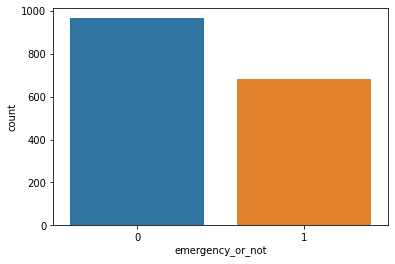

In [11]:
sns.countplot(x='emergency_or_not' , data=train_df)

In [12]:
train_images = train_imagesdf
test_images= test_imagesdf

In [13]:
tfms = get_transforms(do_flip=True,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

test_img = ImageList.from_df(test_df, path=data_folder, folder='images')

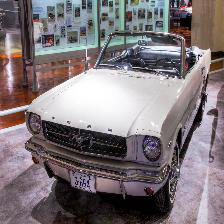

In [14]:
test_img[0]

In [15]:
np.random.seed(145)
## create source of train image databunch
src = (ImageList.from_df(train_df, path=data_folder, folder='images')
       .split_by_rand_pct(0.2)
      #  .split_none()
       .label_from_df()
       .add_test(test_img))

In [16]:
data = (src.transform(tfms, size=299,padding_mode='reflection',resize_method=ResizeMethod.SQUISH)
        .databunch(path='.', bs=32, device= torch.device('cuda:0')).normalize(imagenet_stats))

In [17]:
print(data.classes)

[0, 1]


In [18]:
#resnet152, densenet201, resnet101
learn = cnn_learner(data=data, base_arch=models.resnet101, metrics=[FBeta(beta=1, average='macro'), accuracy],
                    callback_fns=ShowGraph)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [19]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         4,096      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
___________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-05
Min loss divided by 10: 1.91E-03


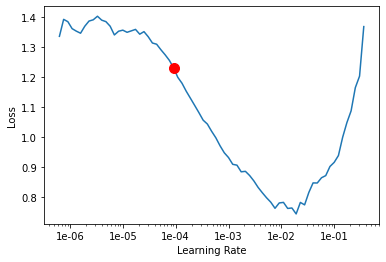

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.444030,0.247688,0.931061,0.933131,01:12
1,0.345835,0.318600,0.917553,0.920973,01:08
2,0.288398,0.377655,0.917337,0.920973,01:08
3,0.240887,0.279561,0.929039,0.933131,01:08
4,0.186726,0.200597,0.936580,0.939210,01:08
5,0.141630,0.220651,0.936062,0.939210,01:08
6,0.100447,0.186020,0.949264,0.951368,01:08
7,0.095417,0.186623,0.942922,0.945289,01:08
8,0.064255,0.163378,0.949264,0.951368,01:08
9,0.057275,0.176826,0.955606,0.957447,01:08


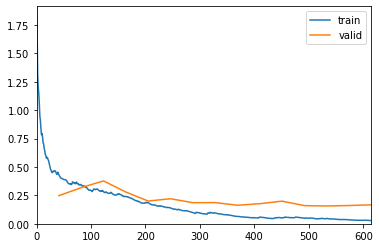

In [21]:
lr = 3e-03
#learn.fit_one_cycle(10, slice(lr))
learn.fit_one_cycle(15, slice(lr), wd=0.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-06


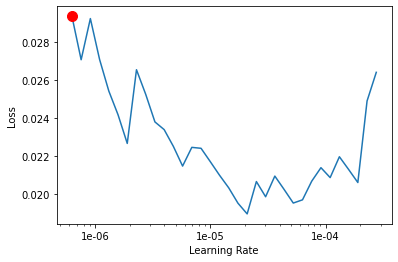

In [23]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.035469,0.167403,0.958829,0.960486,01:29
1,0.037905,0.192872,0.952496,0.954407,01:29
2,0.074963,0.261674,0.916574,0.917933,01:29
3,0.093488,0.189777,0.939672,0.942249,01:29
4,0.066275,0.185591,0.949517,0.951368,01:29
5,0.044345,0.150984,0.955718,0.957447,01:29
6,0.044698,0.158536,0.955827,0.957447,01:28
7,0.032094,0.159100,0.955718,0.957447,01:29
8,0.020165,0.146708,0.955718,0.957447,01:29
9,0.013612,0.158688,0.955718,0.957447,01:29


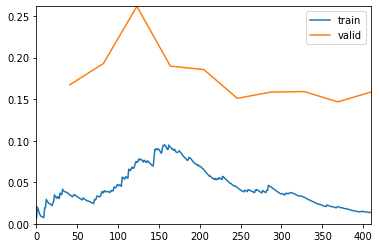

In [24]:
learn.fit_one_cycle(10,slice(1e-05,lr/8),wd=0.15)

In [25]:
learn.freeze_to(-10)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


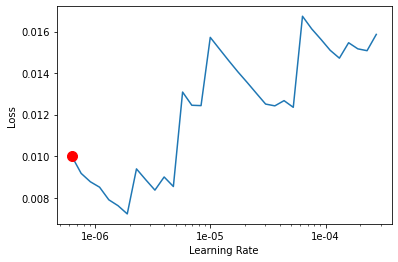

In [26]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.015593,0.158437,0.958932,0.960486,01:30
1,0.018070,0.164868,0.959031,0.960486,01:29
2,0.021880,0.159398,0.959031,0.960486,01:29
3,0.015392,0.178819,0.952614,0.954407,01:29
4,0.009580,0.179873,0.949392,0.951368,01:29
5,0.009671,0.183109,0.952614,0.954407,01:29


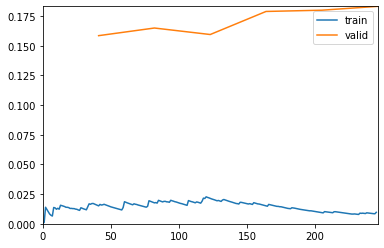

In [27]:
learn.fit_one_cycle(6, slice(1.1e-06, lr/10),wd=0.1)

In [28]:
learn.freeze_to(-3)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.010801,0.182491,0.952614,0.954407,01:29
1,0.011341,0.180841,0.958932,0.960486,01:30
2,0.014580,0.173629,0.958932,0.960486,01:30
3,0.010460,0.170254,0.959031,0.960486,01:30
4,0.011146,0.167539,0.959031,0.960486,01:30
5,0.009146,0.169543,0.959031,0.960486,01:30


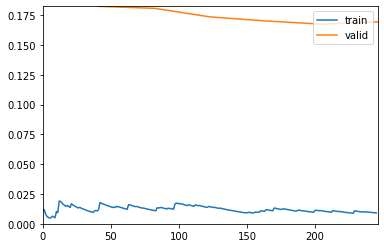

In [29]:
learn.fit_one_cycle(6, slice(4e-07, lr/20),wd=0.1)

In [ ]:
learn.freeze_to(-2)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.014983,0.202553,0.965334,0.966565,00:47
1,0.013094,0.198812,0.965334,0.966565,00:47
2,0.015565,0.201992,0.962137,0.963526,00:47
3,0.017525,0.197177,0.962227,0.963526,00:47
4,0.014969,0.195130,0.962227,0.963526,00:47


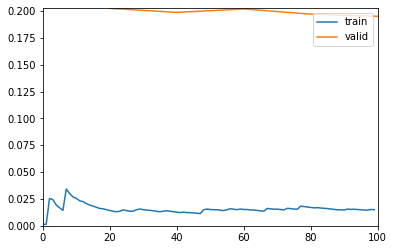

In [ ]:
learn.fit_one_cycle(5, slice(5e-07, lr/20),wd=0.1)

epoch,train_loss,valid_loss,f_beta,accuracy,time
0,0.005036,0.180168,0.962137,0.963526,00:18
1,0.008676,0.175676,0.962137,0.963526,00:19
2,0.007782,0.171724,0.965334,0.966565,00:19
3,0.008600,0.167103,0.965334,0.966565,00:19
4,0.008219,0.168360,0.965334,0.966565,00:18
5,0.007756,0.176110,0.965334,0.966565,00:18


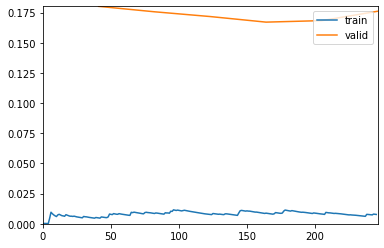

In [ ]:
learn.fit_one_cycle(6, slice(1e-07, lr/100))

In [ ]:
pred_val,y = learn.TTA(ds_type=DatasetType.Valid)
from sklearn.metrics import f1_score, accuracy_score
valid_preds = [np.argmax(pred_val[i])+1 for i in range(len(pred_val))]
valid_preds = np.array(valid_preds)
y = np.array(y+1)
accuracy_score(valid_preds,y),f1_score(valid_preds,y, average='micro')

In [ ]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
# preds,_ = learn.get_preds(ds_type = DatasetType.Test)
labelled_preds = [np.argmax(preds[i]) for i in range(len(preds))]
labelled_preds = np.array(labelled_preds)

In [ ]:
df = pd.DataFrame({'image_names':test_df['image_names'], 'emergency_or_not':labelled_preds}, columns=['image_names', 'emergency_or_not'])
# df["emergency_or_not"] = df["emergency_or_not"]
df.to_csv('submission3.csv', index=False)